# Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.
This tutorial explains the main features in walk-through examples. It covers:

1. Basic usage
2. Plotting
3. Integrating (expert) assumptions about links
4. Benchmarking and validation
5. Causal effect estimation
6. Dataset challenges
7. Sliding window analysis

See the following paper for theoretical background:
Runge, Jakob. 2018. “Causal Network Reconstruction from Time Series: From Theoretical Assumptions to Practical Estimation.” Chaos: An Interdisciplinary Journal of Nonlinear Science 28 (7): 075310.

Last, the following Nature Review Earth and Environment paper provides an overview of causal inference for time series in general: https://github.com/jakobrunge/tigramite/blob/master/tutorials/Runge_Causal_Inference_for_Time_Series_NREE.pdf

## 1. Basic usage

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.lpcmci import LPCMCI

from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.parcorr_wls import ParCorrWLS 
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb
from tigramite.independence_tests.gsquared import Gsquared
from tigramite.independence_tests.regressionCI import RegressionCI

Tigramite provides several causal discovery methods from the PCMCI framework that can be used under different sets of assumptions. An application always consists of a method and a chosen conditional independence test. , e.g. PCMCI together with ParCorr. The following two tables give an overview of the assumptions involved:

| Method | Assumptions         | Output |
| :-- | :-- | :-- |
|         |   (in addition to Causal Markov Condition and Faithfulness)   |    |
| PCMCI  | Causal stationarity, no contemporaneous causal links, no hidden variables |  Directed lagged links, undirected contemporaneous links (for tau_min=0)  |
| PCMCIplus | Causal stationarity, no hidden variables    | Directed lagged links, directed and undirected contemp. links (Time series CPDAG) |
| LPCMCI | Causal stationarity    | Time series PAG |
| RPCMCI  | No contemporaneous causal links, no hidden variables |  Regime-variable and causal graphs for each regime with directed lagged links, undirected contemporaneous links (for tau_min=0)  |
| J-PCMCI+ | Multiple datasets, causal stationarity, no hidden system confounding, except if context-related   | Directed lagged links, directed and undirected contemp. links (Joint time series CPDAG) |


| Conditional independence test | Assumptions                                  |
| :-- | :-- | 
| ParCorr  | univariate, continuous variables with linear dependencies and Gaussian noise |
| RobustParCorr  | univariate, continuous variables with linear dependencies, robust for different marginal distributions |
| ParCorrWLS  | univariate, continuous variables with linear dependencies, can account for heteroskedastic data |
| GPDC / GPDCtorch | univariate, continuous variables with additive dependencies        |
| CMIknn | multivariate, continuous variables with more general dependencies (permutation-based test)          |
| Gsquared | univariate discrete/categorical variables           |
| CMIsymb | multivariate discrete/categorical variables (permutation-based test)           |
| RegressionCI | mixed datasets with univariate discrete/categorical and (linear) continuous variables 
| PairwiseMultCI | Meta-conditional independence test that turns every univariate test above into a multivariate test incl a method that may help increase effect size

References for the methods are in the docstrings of the methods and the corresponding tutorials.

References for the conditional independence tests are covered in the respective tutorial ``conditional_independence_tests``. The following steps will walk you through a typical causal analysis.

### A toy model

Consider time series coming from a data generating process

\begin{align*}
X^0_t &= 0.7 X^0_{t-1} - 0.8 X^1_{t-1} + \eta^0_t\\
X^1_t &= 0.8 X^1_{t-1} + 0.8 X^3_{t-1} + \eta^1_t\\
X^2_t &= 0.5 X^2_{t-1} + 0.5 X^1_{t-2} + 0.6 X^3_{t-3} + \eta^2_t\\
X^3_t &= 0.7 X^3_{t-1} + \eta^3_t\\
\end{align*}

where $\eta$ are independent zero-mean unit variance random variables. Our goal is to reconstruct the drivers of each variable. In Tigramite such a process can be generated with the function ``toys.structural_causal_process``.

In [2]:
seed = 42
np.random.seed(seed)     # Fix random seed
def lin_f(x): return x
links_coeffs = {0: [((0, -1), 0.7, lin_f), ((1, -1), -0.8, lin_f)],
                1: [((1, -1), 0.8, lin_f), ((3, -1), 0.8, lin_f)],
                2: [((2, -1), 0.5, lin_f), ((1, -2), 0.5, lin_f), ((3, -3), 0.6, lin_f)],
                3: [((3, -1), 0.4, lin_f)],
                }
T = 1000     # time series length
data, _ = toys.structural_causal_process(links_coeffs, T=T, seed=seed)
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, 
                         datatime = {0:np.arange(len(data))}, 
                         var_names=var_names)


### Always the first step: Plot the data

This can be done with the function ``tp.plot_timeseries``

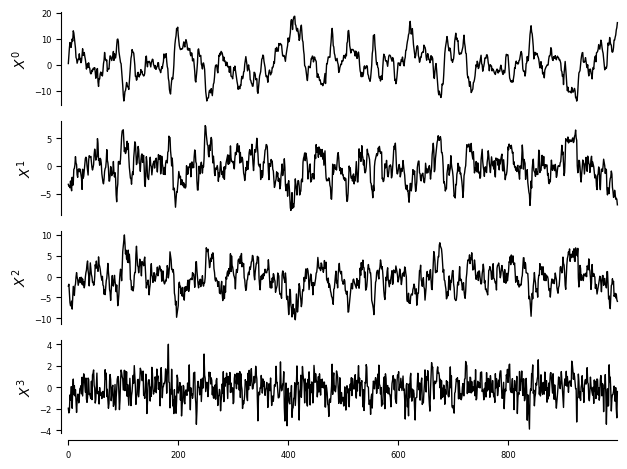

In [3]:
tp.plot_timeseries(dataframe); plt.show()

It's stationary (could be checked in addition) and doesn't contain missing values (covered in tutorial ``missing_masking``).

We now make the assumptions of causal stationarity, no hidden variables, and only lagged dependencies. Hence, we choose ``PCMCI`` as the causal discovery method. Next, we need to choose the conditional independence test and hyperparameters such as the maximum time lag ``tau_max``. To do so, we investigate the data.

### Investigating data dependencies and lag functions

To investigate the type of dependencies, we use the ``plot_scatterplots`` and  ``plot_densityplots`` functions to see whether the dependencies are really linear. With the argument ``matrix_lags`` set to a ``(N, N)`` integer numpy array you can choose which lag to use for every pair of variables. Here it is left ``None`` implying lag zero.

In [4]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


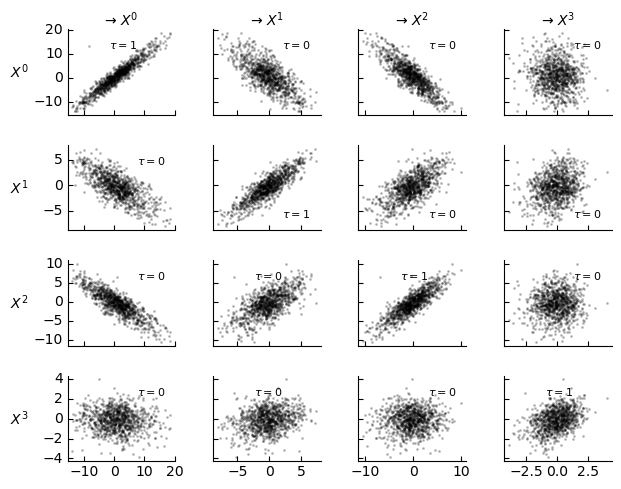

In [5]:
matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
tp.plot_scatterplots(dataframe=dataframe, add_scatterplot_args={'matrix_lags':matrix_lags}); plt.show()

(The diagonal panels show the lag-zero scatter plots of variables with itself here.)

Next, we investigate kernel density estimates of the joint and marginal (diagonal panels) densities.

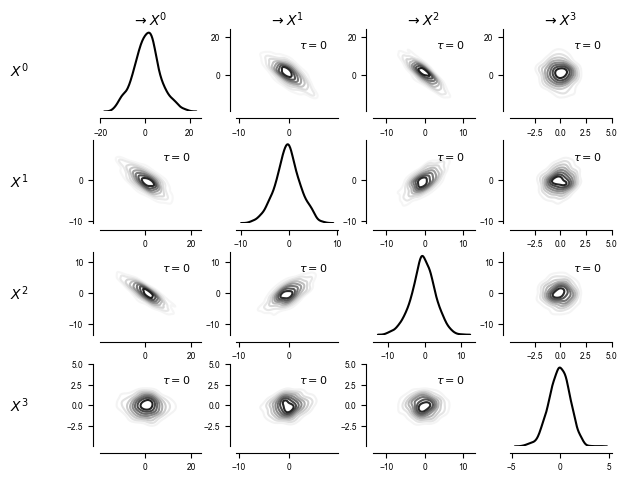

In [6]:
tp.plot_densityplots(dataframe=dataframe, add_densityplot_args={'matrix_lags':matrix_lags})
plt.show()

Since in our toy model the dependencies appear reasonably linear and the distributions Gaussian, we use the ``ParCorr`` conditional independence test implementing linear partial correlation. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. 

Next, it's a good idea to plot the lagged unconditional dependencies, e.g., the lagged correlations using the ``ParCorr`` class. This can help to identify which maximal time lag ``tau_max`` to choose in the causal algorithm.
 
To this end we initialize the ``PCMCI`` method with  ``dataframe``, and ``ParCorr`` as a ``cond_ind_test``. 

In [7]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


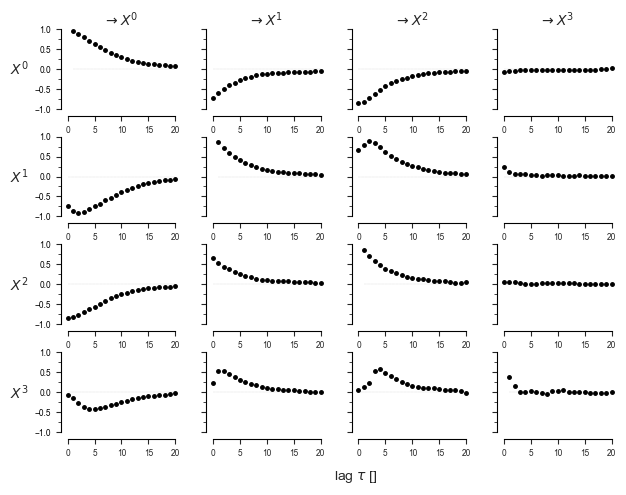

In [8]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

Alternatively to investigating the scatter plots and densities above at lag zero, one may choose the lag at which the dependencies have their maximal absolute value. Of course, you might want to use a nonlinear conditional independence test to assess the lags with maximum dependency. I.e., run ``pcmci.get_lagged_dependencies`` with ``PCMCI`` initialized with a nonlinear measure (e.g., CMIknn or GPDC as introduced in the conditional independence test tutorial).



## PCMCI causal discovery

Here, since the dependencies in the lag function plot above decay beyond a maximum lag of around 8, we choose ``tau_max=8`` for PCMCI. The other main parameter is ``pc_alpha`` which sets the significance level in the condition-selection step. Here we let PCMCI choose the optimal value by setting it to ``pc_alpha=None``. Then PCMCI will optimize this parameter in the ParCorr case by the Akaike Information criterion among a reasonable default list of values (e.g., ``pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]``). The parameter ``alpha_level=0.01`` indicates that we threshold the resulting p-value matrix at this significance level to obtain the graph. 

In [9]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None, alpha_level=0.01)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $X^0$ has 5 link(s):
    [pc_alpha = 0.1]
        ($X^0$ -1): max_pval = 0.00000, |min_val| =  0.816
        ($X^1$ -1): max_pval = 0.00000, |min_val| =  0.729
        ($X^3$ -4): max_pval = 0.04439, |min_val| =  0.064
        ($X^2$ -5): max_pval = 0.06669, |min_val| =  0.059
        ($X^3$ -1): max_pval = 0.08886, |min_val| =  0.054

    Variable $X^1$ has 2 link(s):
    [pc_alpha = 0.05]
        ($X^1$ -1): max_pval = 0.00000, |min_val| =  0.700
        ($X^3$ -1): max_pval = 0.00000, |min_val| =  0.522

    Variable $X^2$ has 3 link(s):
    [pc_alpha = 0.1]
        ($X^2$ -1): max_pval = 0.00000, |min_val| =  0.450
        ($X^1$ -2): max_pval = 0.00000, |min_val| =  0.429
        ($X^3$ -3): max_pval = 0.00000, |m

As you can see from the output, PCMCI selected different ``pc_alpha`` for each variable. The result of ``run_pcmci`` is a dictionary containing the matrix of p-values, the matrix of test statistic values (here MCI partial correlations) and optionally its confidence bounds (can be specified upon initializing ``ParCorr``), and the ``graph`` matrix. ``p_matrix`` and ``val_matrix`` are of shape ``(N, N, tau_max+1)`` with entry $(i, j, \tau)$ denoting the test for the link $X^i_{t-\tau} \to X^j_t$. The MCI values for $\tau=0$ do not exclude other contemporaneous effects, only past variables are conditioned upon. The ``graph`` array of the same shape is obtained from thresholding the ``p_matrix`` at the specified ``alpha_level``. It is a string array and denotes significant lagged causal links by ``-->`` and contemporaneou links (where the orientation cannot be determined with PCMCI) by ``o-o``. With the PCMCIplus method also contemporaneous links can be oriented.

__Note:__ The test statistic values (e.g., partial correlation) may give a qualitative intuition of the `strength` of a dependency, but for a proper causal effect analysis please refer to the ``CausalEffects`` class and tutorial.

In [10]:
print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

p-values
[[[1.    0.    0.552 0.504 0.935 0.954 0.59  0.699 0.095]
  [0.434 0.389 0.769 0.14  0.643 0.155 0.148 0.15  0.675]
  [0.97  0.191 0.846 0.441 0.688 0.815 0.736 0.066 0.765]
  [0.185 0.761 0.643 0.078 0.262 0.176 0.535 0.757 0.282]]

 [[0.434 0.    0.844 0.629 0.566 0.83  0.265 0.62  0.921]
  [1.    0.    0.324 0.885 0.074 0.17  0.861 0.639 0.766]
  [0.425 0.654 0.    0.478 0.663 0.202 0.34  0.618 0.359]
  [0.354 0.276 0.909 0.097 0.981 0.617 0.882 0.947 0.654]]

 [[0.97  0.986 0.887 0.16  0.794 0.065 0.555 0.563 0.024]
  [0.425 0.048 0.752 0.759 0.846 0.314 0.63  0.763 0.876]
  [1.    0.    0.474 0.664 0.371 0.991 0.647 0.874 0.336]
  [0.306 0.721 0.473 0.861 0.97  0.143 0.569 0.931 0.123]]

 [[0.185 0.119 0.851 0.775 0.029 0.449 0.782 0.552 0.322]
  [0.354 0.    0.548 0.087 0.651 0.894 0.046 0.898 0.407]
  [0.306 0.341 0.756 0.    0.389 0.226 0.819 0.336 0.566]
  [1.    0.    0.277 0.07  0.316 0.616 0.43  0.677 0.023]]]
MCI partial correlations
[[[ 0.    0.56  0.02  0.02  0.

### False-discovery rate control

If we want to control for the $N^2 \tau_\max$ tests conducted here, we can further correct the p-values, e.g., by False Discovery Rate (FDR) control yielding the ``q_matrix``. The graph can then be updated with that adjusted ``p_matrix`` and a different ``alpha_level`` using ``get_graph_from_pmatrix()``.

In [11]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)
graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=0.01, 
            tau_min=0, tau_max=8, link_assumptions=None)
results['graph'] = graph


## Significant links at alpha = 0.01:

    Variable $X^0$ has 2 link(s):
        ($X^1$ -1): pval = 0.00000 | val = -0.619
        ($X^0$ -1): pval = 0.00000 | val =  0.559

    Variable $X^1$ has 2 link(s):
        ($X^3$ -1): pval = 0.00000 | val =  0.638
        ($X^1$ -1): pval = 0.00000 | val =  0.628

    Variable $X^2$ has 3 link(s):
        ($X^3$ -3): pval = 0.00000 | val =  0.452
        ($X^1$ -2): pval = 0.00000 | val =  0.429
        ($X^2$ -1): pval = 0.00000 | val =  0.422

    Variable $X^3$ has 1 link(s):
        ($X^3$ -1): pval = 0.00000 | val =  0.350


### Further relevant methodological tutorials

The tutorial ``assumptions`` explains the underlying assumptions of causal discovery and how violations of these affect the methods.

Here we showcased ``run_pcmci`` which assumes no contemporaneous causal links. Have a look at ``run_pcmciplus`` in the corresponding tutorial ``pcmciplus`` for a method that can also detect (and account for confounding due to) contemporaneous causal links.

The tutorial ``latent-pcmci`` explains the class ``LPCMCI`` that can be used if you want to allow for hidden confounding in addition to contemporaneous links.

the tutorial ``tigramite_tutorial_jpcmciplus`` shows how to utilize multiple datasets to learn joint causal graphs and overcome some kinds of hidden confounding.

The tutorial ``conditional_independence_tests`` gives an overview of all conditional independence tests available in tigramite, including those for nonlinear and categorical variables.

The tutorial ``tigramite_tutorial_bootstrap_aggregation`` shows how bootstrap can be used for more robust causal graphs and confidence estimation of links.

The tutorial ``pcmci_fullci`` compares PCMCI with alternative estimators of vector-autoregressive models.

## 2. Plotting

Tigramite offers several plotting options: The lag function matrix (as shown above), the time series graph, and the process graph which aggregates the information in the time series graph. Both take as arguments the ``graph`` array and optionally the ``val_matrix`` and further link attributes.

In the process graph, the node color denotes the auto-MCI value and the link colors the cross-MCI value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength. Additionally, setting ``show_autodependency_lags=True`` will display the significant auto dependencies below the respective node labels.

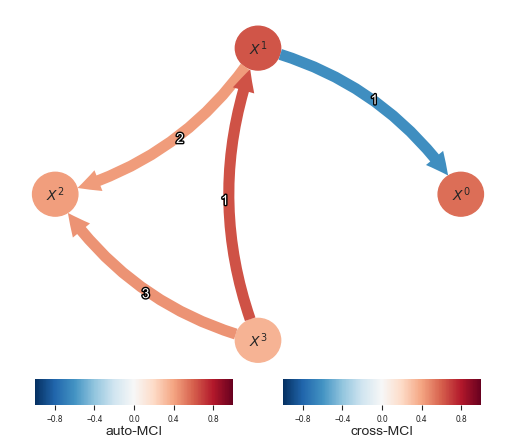

In [12]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=False
    ); plt.show()

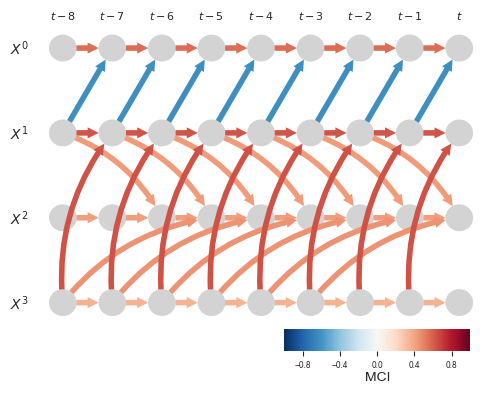

In [13]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off. You can adjust the size and aspect ratio of nodes with `node_size` and `node_aspect` parameters, and also modify many other properties, see the parameters of `plot_graph` and `plot_time_series_graph`.

Alternatively, the links can also be exported to a ``csv``-file:

In [14]:
tp.write_csv(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    save_name='test_graph.csv',
    digits=5,
)

## 3. Integrating expert assumptions about links

Often one may have prior knowledge about the existence or absence of links and their orientations. Such expert knowledge can be intergrated via the ``link_assumptions`` argument.

``link_assumptions`` is a dictionary of the form ``{j:{(i, -tau): link_type, ...}, ...}`` specifying assumptions about links. Internally, setting this argument initializes the graph with ``graph[i,j,tau] = link_type`` for a dictionary entry ``link_assumptions[j][(i, -tau)] = link_type``. The following specifications are allowed:

-``graph[i,j,0] = '-->'``: an oriented link from i to j at lag 0 exists

-``graph[i,j,0] = '-?>'``: let the method test for an adjacency and if it exists, then its orientation is from i to j at lag 0

-``graph[i,j,0] = 'o-o'``: an adjacency between i and j at lag 0 exists, but let the method determine its orientation

-``graph[i,j,0] = 'o?o'``: let the method test for an adjacency and its orientation (default)

Link assumptions need to be consistent, i.e., ``graph[i,j,0] = '-->'`` requires ``graph[j,i,0] = '<--'`` and acyclicity must hold. If a link does not appear in the dictionary, it is assumed absent. That is, if ``link_assumptions`` is not None, then all links have to be specified or the links are assumed absent.

There might be cases in which you have background knowledge on only a small number of the possible links and it is cumbersome to build the full nested dictionary, where absence of background knowledge needs to be specified by `link_assumptions[j][(i, tau)] = '-?>` for ``tau < 0`` and by `link_assumptions[j][(i, 0)] = 'o?o'` for ``tau = 0``. In such cases, you can use the static convenience function ``pcmci.build_link_assumptions(...)`` in your code or notebook which allows to build the implemented ``link_assumptions`` (which assumes absent entries to be absent links) by ``link_assumptions_absent_link_means_no_knowledge`` (which assumes absent entries are default assumptions about links).

Consider the following example.

In [15]:
links_coeffs = {0: [((0, -1), 0.7, lin_f)],
                1: [((1, -1), 0.7, lin_f), ((0, 0), 0.2, lin_f), ((2, -2), 0.2, lin_f)],
                2: [((2, -1), 0.9, lin_f)],
                }
T = 100     # time series length
data, _ = toys.structural_causal_process(links_coeffs, T=T, seed=8)
T, N = data.shape

# Initialize dataframe object
dataframe = pp.DataFrame(data)
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=ParCorr(),
    verbosity=0)


We first run PCMCIplus (allows to detect contemporaneous links) without link assumptions (default).

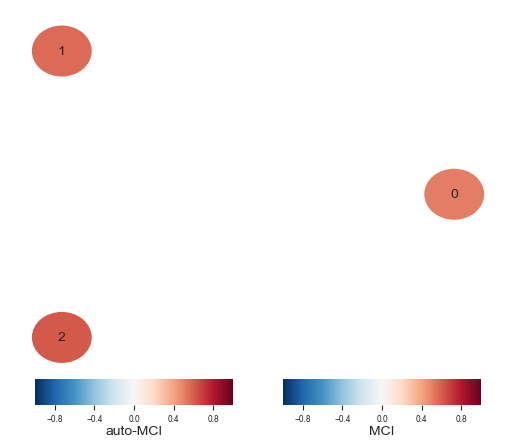

In [16]:
tau_max = 2
pc_alpha = 0.05
link_assumptions = None
results = pcmci.run_pcmciplus(tau_max=tau_max, 
                              pc_alpha=pc_alpha,
                              link_assumptions=link_assumptions,
                             )
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    ); plt.show()

Here, due to small sample size and weak link strength, we miss both links from 0 to 1 (lag 0) and from 2 to 1 (lag 2).

Now we assume that the link from 0 to 1 at lag 0 must be there, but its orientation is not fixed, and the link from 2 to 1 at lag 2 (orientation then given by time order). Further, we assume no links between 0 and 2 (at any lag):

[['' '-->' '']
 ['<--' '' '']
 ['' '' '']]


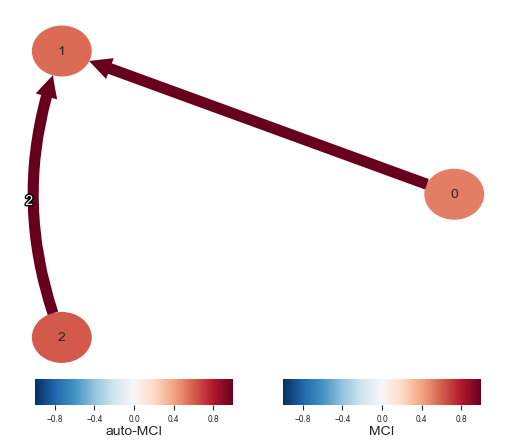

In [17]:
link_assumptions = {j:{(i, -tau):'o?o' for i in range(N) for tau in range(tau_max + 1) if (i, -tau) != (j, 0)} 
                            for j in range(N)}

# Exclude all links between 0 and 2
link_assumptions[0] = {(i, -tau):'o?o' for i in range(N) for tau in range(tau_max + 1) 
                       if ((i, -tau) != (0, 0)
                        and i != 2)} 
link_assumptions[2] = {(i, -tau):'o?o' for i in range(N) for tau in range(tau_max + 1) 
                       if ((i, -tau) != (2, 0)
                        and i != 0)} 

# Set link 1 o-o 0 at lag 0
link_assumptions[1][(0, 0)] = 'o-o'
link_assumptions[0][(1, 0)] = 'o-o'    # Required for consistency of contemporaneous links, would be internally added if not present
# Set link 2 --> 1 at lag 2
link_assumptions[1][(2, -2)] = '-->'

results = pcmci.run_pcmciplus(tau_max=tau_max, 
                              pc_alpha=pc_alpha,
                              link_assumptions=link_assumptions,
                             )
print(results['graph'][:,:,0])
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    ); plt.show()

This gives the correct graph. Note that we did *not* specify the orientation of the link ``1 <-- 0``, only the adjacency ``1 o-o 0``. The orientation was inferred by PCMCIplus in the collider rule. See the corresponding tutorial on PCMCIplus.

## 4. Benchmarking and validation

It is advisable to create toy model data yourself that features the same challenges as your real data, but where the ground truth is known such that you can evaluate which method works best and also to choose hyperparameters.

See the tutorials in the corresponding folder.

## 5. Causal effect estimation

The plots above indicate a link's *causal strength* as the test statistic value of the corresponding independence test. However, this can not straighforwardly be interpreted as a causal effect measure. This is covered by the ``CausalEffect`` and ``LinearMediation`` classes.

See the tutorials in the corresponding folder.

## 6. Dataset challenges

Finally, you may have more than one dataset and/or challenges such as missing or masking which are covered by the functionalities of the tigramite ``DataFrame``.

See the tutorials in the corresponding folder.

## 7. Sliding window analysis

The tutorial ``sliding_window_analysis`` explains the function PCMCI.run_sliding_window_of which is a convenience function that allows to run all PCMCI causal discovery methods on sliding windows across a multivariate time series.